# Import Library

In [1]:
import os, os.path as osp
from glob import glob
from natsort import os_sorted
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Input parameter

In [ ]:
# Input folder data
input_dir = 'SSC'

# split train folder into train and validation
split_train = 0.8

# Parameter for data segmentation
frame_len = 100  #จำนวน frame ต่อ 1 ชุดข้อมูล  2940 // ใช้ 100
hop_len = 50 # ระยะเหลื่อมระหว่าง frame 2940 // ใช้ 50

'''  Example
    --------
frame_len = 3
hop_len = 2

x = np.array([
    [0, 1, 2],
    [10, 11, 12],
    [20, 21, 22],
    [30, 31, 32],
    [40, 41, 42],
    [50, 51, 52],
    [60, 61, 62],
    [70, 71, 72]
])

📌 เฟรมที่ 1:
[[ 0  1  2]
 [10 11 12] 
 [20 21 22]]

📌 เฟรมที่ 2:
[[20 21 22]
 [30 31 32]
 [40 41 42]]

📌 เฟรมที่ 3:
[[40 41 42]
 [50 51 52]
 [60 61 62]]
'''


# Load csv path

In [3]:
train_dir = input_dir + '/train'
test_dir = input_dir + '/test'
df_paths = glob(osp.join(train_dir, '*', '*.csv'))

# Visualize DataFrame

In [4]:
def plot_activity(activity,df,start=0,stop=-1):
    df = df.iloc[start:stop]

    ax = df.plot(subplots=True,figsize=(16,12),title=activity+ ', Start Row: '+str(start)+' Stop row: '+str(stop)) # Plot accelerometer for the activity.

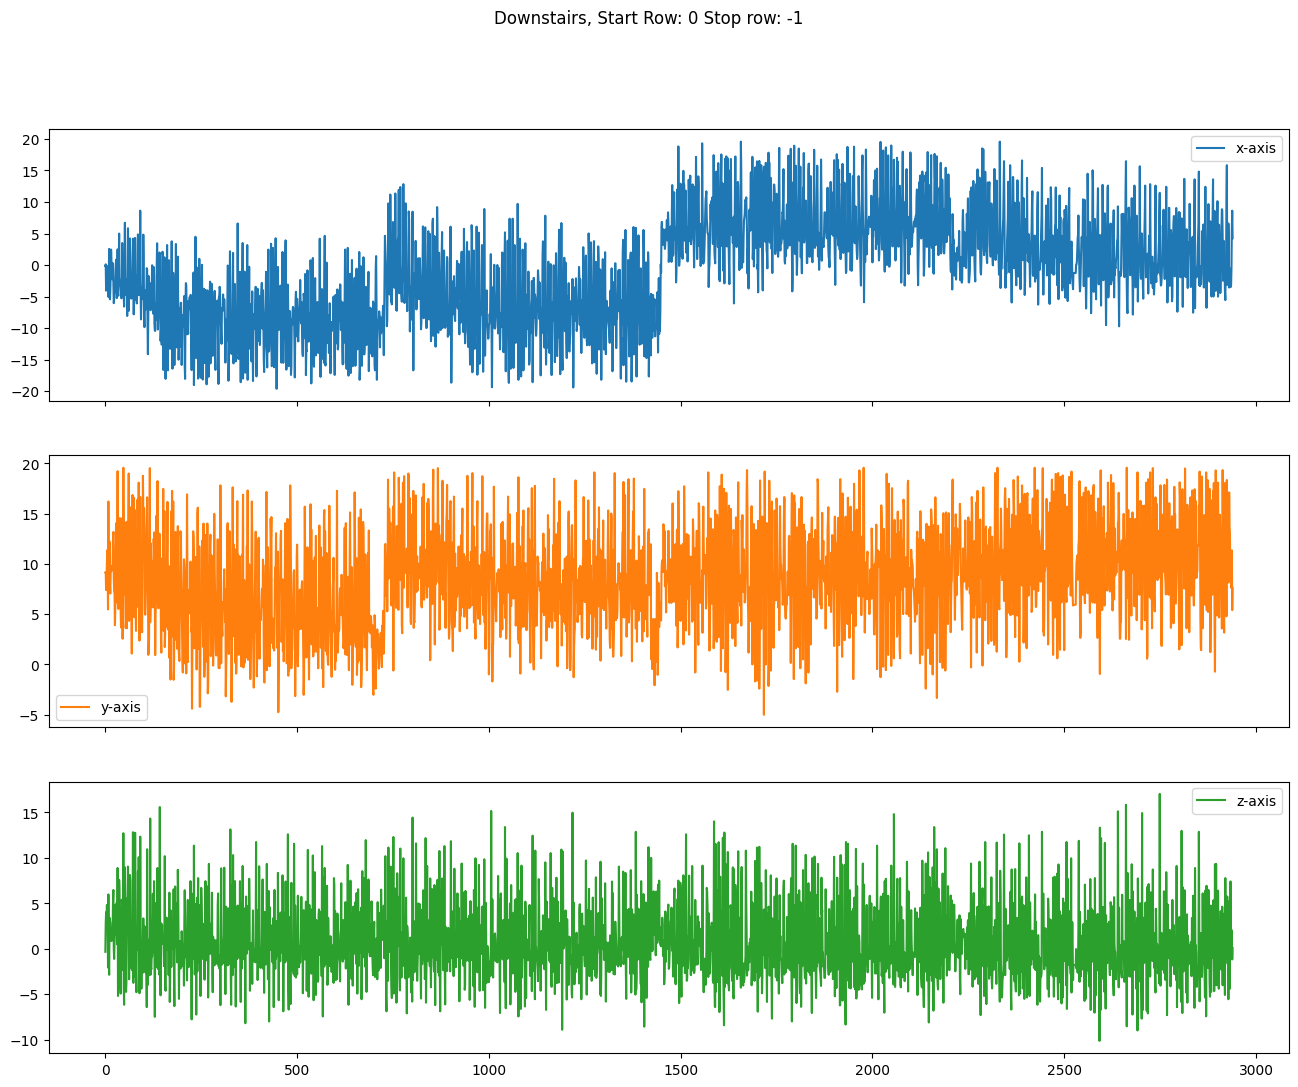

In [5]:
path = df_paths[0]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

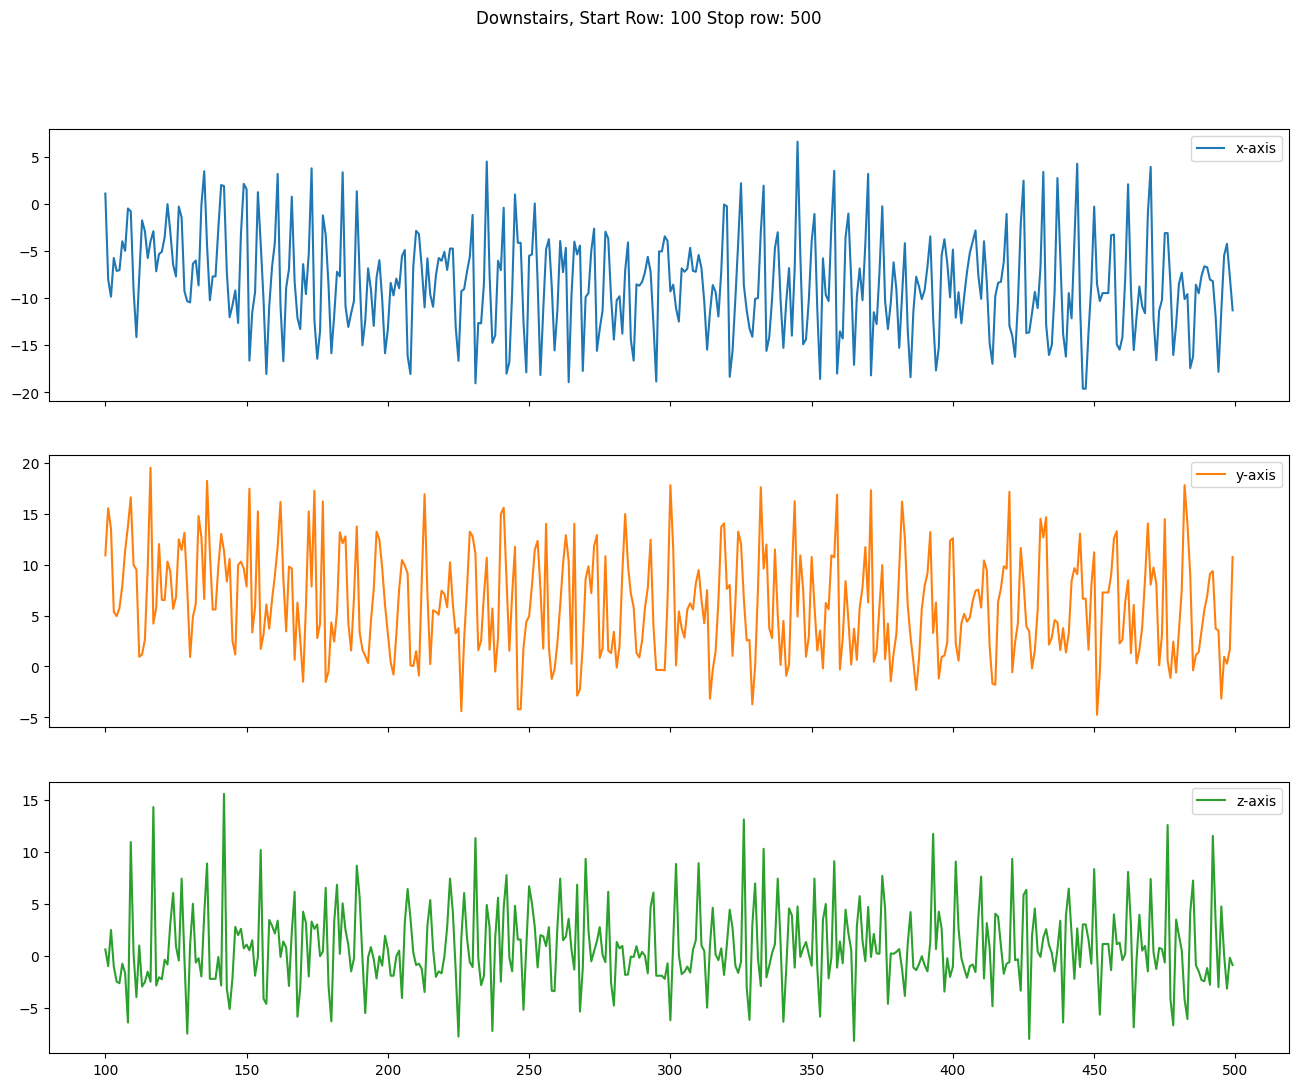

In [6]:
plot_activity(activity,df,100,500)

# Training, Validation Data

We'll use 80% of the measurements for training and validation.

In [7]:
from sklearn.model_selection import train_test_split

dataset_paths = {'train': [], 'val': []}

for activity_dir in glob(osp.join(train_dir, '*')):
    paths = glob(osp.join(activity_dir, '*.csv'))
    train_paths, val_paths = train_test_split(paths , test_size = 0.2 )
    dataset_paths['train'].extend(train_paths)
    dataset_paths['val'].extend(val_paths)

In [8]:
len(dataset_paths['train']), len(dataset_paths['val'])

(111, 32)

# Load Dataset

In [9]:
def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

**Load and preprocess data**

In [10]:
from sklearn.preprocessing import StandardScaler

dataset_blocks = {'train': {'block': [], 'label': []},
                  'val': {'block': [], 'label': []}}

for dataset in ['train', 'val']:
    paths = dataset_paths[dataset]

    for path in paths:
        activity = path.split(os.sep)[-2]
        df = pd.read_csv(path)

        # Preprocessing
        mms = StandardScaler()
        for feature in list(df.columns):
            df[feature] = mms.fit_transform(df[[feature]])

        samples = frame(df.loc[:, ].values, frame_len, hop_len)
        labels = np.full(samples.shape[0], activity)

        dataset_blocks[dataset]['block'].extend(samples)
        dataset_blocks[dataset]['label'].extend(labels)

    dataset_blocks[dataset]['block'] = np.array(dataset_blocks[dataset]['block'])
    dataset_blocks[dataset]['label'] = np.array(dataset_blocks[dataset]['label'])

In [11]:
dataset_blocks['train']['block'].shape, dataset_blocks['val']['block'].shape

((13721, 100, 3), (3713, 100, 3))

In [12]:
dataset_blocks['val']['label'][:10]

array(['Downstairs', 'Downstairs', 'Downstairs', 'Downstairs',
       'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs',
       'Downstairs', 'Downstairs'], dtype='<U10')

**One Hot Encode Labels**

In [13]:
LABELS = os_sorted([osp.split(path)[-1] for path in glob(osp.join(train_dir, '*'))])
LABELS

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [14]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']
    one_hot_encoded = np.zeros((labels.size, len(LABELS)))

    for i, label in enumerate(LABELS):
        index = np.where(labels == label)[0]
        one_hot_encoded[index, i] = 1

    dataset_blocks[dataset]['label'] = one_hot_encoded

In [15]:
dataset_blocks['val']['label'][:10]

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

**Visualize**

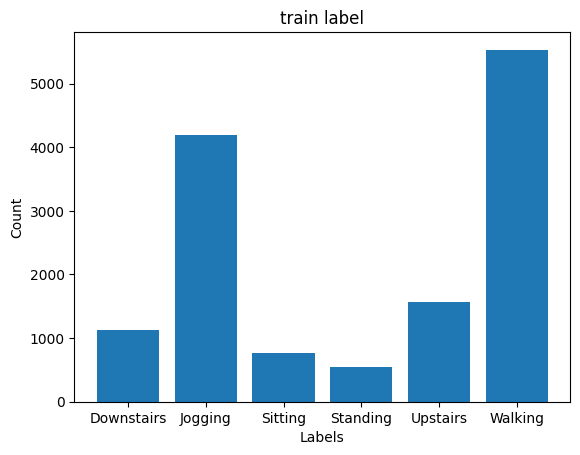

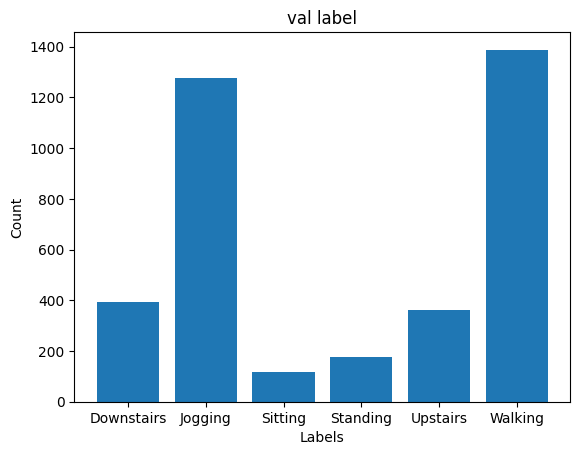

In [16]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']

    labels_sum = labels.sum(axis=0)

    # Plotting
    plt.bar(LABELS, labels_sum)
    plt.title(f'{dataset} label')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# Model

In [17]:
# Get the input shape -> (samples, time steps, features)
X_train = dataset_blocks['train']['block']
Y_train = dataset_blocks['train']['label']

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
print('n_timesteps: {}, n_features: {}, n_outputs: {}'.format(n_timesteps,n_features,n_outputs))

n_timesteps: 100, n_features: 3, n_outputs: 6


In [38]:
import keras
from keras.layers import Conv1D, MaxPooling1D, Input, Dense, Dropout, Flatten, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D

In [ ]:
model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout1D(0.3))

model.add(Conv1D(256, kernel_size=5, activation='relu'))  
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(256, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))

model.add(Dense(n_outputs, activation='softmax'))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 98, 256)        │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 98, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 98, 256)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 94, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_7             │ (None, 47, 256)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 41, 256)        │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,349,894 (5.15 MB)

 Trainable params: 1,349,382 (5.15 MB)

 Non-trainable params: 512 (2.00 KB)

In [33]:
# model = Sequential()
# model.add(Input(shape=(n_timesteps,n_features)))
# model.add(Conv1D(512, 8, activation='relu'))
# model.add(AveragePooling1D(pool_size=2))
# model.add(Dropout(0.2))# เพิ่ม Dropout เพื่อป้องกัน overfitting
# model.add(Conv1D(128, 8, activation='relu'))  # เพิ่ม Conv1D layer อื่น
# model.add(MaxPooling1D())
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(n_outputs, activation='softmax'))


# model.summary()

**Training**

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath= 'best_cnn_model.weights.h5',
        monitor='val_loss', save_best_only=True, save_weights_only=True
    ),
]

epochs = 10
batch_size = 32

In [42]:
history = model.fit(dataset_blocks['train']['block'],
                    dataset_blocks['train']['label'],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(dataset_blocks['val']['block'],
                                     dataset_blocks['val']['label']),
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7060 - loss: 0.7618 - val_accuracy: 0.6844 - val_loss: 1.1025
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.8925 - loss: 0.2808 - val_accuracy: 0.7250 - val_loss: 1.2554
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9388 - loss: 0.1658 - val_accuracy: 0.7468 - val_loss: 1.2826
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.9487 - loss: 0.1385 - val_accuracy: 0.7309 - val_loss: 1.2633
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9612 - loss: 0.1020 - val_accuracy: 0.7444 - val_loss: 1.1576
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.9643 - loss: 0.0909 - val_accuracy: 0.7511 - val_loss: 1.1416
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9729 - loss: 0.0784 - val_accuracy: 0.7576 - val_loss: 1.3313
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.9720 - loss: 0.0771 - 

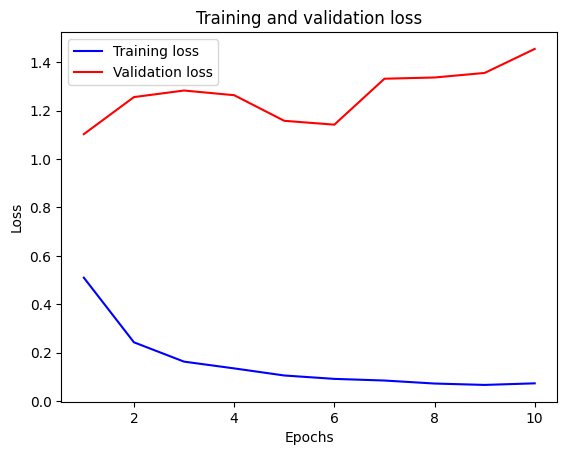

In [43]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Validation**

In [44]:
# evaluate model
loss, accuracy = model.evaluate(dataset_blocks['val']['block'],
                                dataset_blocks['val']['label'], batch_size=batch_size, verbose=0)
print(f'Loss : {loss}')
print(f'Accuracy: {accuracy}')

Loss : 1.45437490940094
Accuracy: 0.7384864091873169


# Submission

In [50]:
from sklearn.preprocessing import StandardScaler

answer_list = []

for filename in tqdm(glob(test_dir + '/*.csv')):
    
    # Read test csv file
    df = pd.read_csv(filename)

    # Preprocessing
    mms = StandardScaler()
    for feature in list(df.columns):
        df[feature] = mms.fit_transform(df[[feature]])

    samples = df.loc[:, ].values
    
    # Predict
    y_pred_prob = model.predict(np.array(samples).reshape(-1,frame_len,n_features), verbose = 0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    class_names = LABELS[y_pred[0]]
    
    normalized_filename = filename.replace("\\", "/") 

    value = (normalized_filename.split('/')[-1], class_names)
    
    answer_list.append(value)

  1%|          | 4/693 [00:00<00:53, 12.84it/s]

('003d40b5-56ed-43cc-a4cc-5c901d542afc.csv', 'Downstairs')
('004c721f-2a5c-45ca-9faa-54b0c5e2188b.csv', 'Jogging')
('005af30b-08f6-4695-9509-41a9f2722c2e.csv', 'Standing')
('00975e94-b081-4c14-962f-026acc55d9f3.csv', 'Walking')


  1%|          | 6/693 [00:00<00:51, 13.26it/s]

('00dccf4d-375c-4d95-9441-7ff0d3687314.csv', 'Walking')
('011f5906-a428-40dd-b55d-bf4c91fcc6fe.csv', 'Downstairs')
('015180f5-89d6-4e06-91a0-bd3800c1738e.csv', 'Jogging')


  1%|▏         | 10/693 [00:00<00:51, 13.19it/s]

('016c611d-5203-4711-a053-aaa1ca0074d6.csv', 'Walking')
('024047f3-03c6-4685-979d-e28428c294bc.csv', 'Jogging')
('02449fc9-1eae-431f-aa48-8d9dfa7df510.csv', 'Jogging')


  2%|▏         | 12/693 [00:00<00:51, 13.16it/s]

('029f4223-443a-4f38-a770-d0896c316969.csv', 'Jogging')
('02d246ba-050b-42c0-af6e-9bd4ad1b233b.csv', 'Walking')
('02e01832-1605-476c-997c-9cbb82508915.csv', 'Walking')


  2%|▏         | 16/693 [00:01<00:51, 13.23it/s]

('0301b246-686a-441f-800f-5ff474fd60ab.csv', 'Upstairs')
('03102e41-ed1a-43b9-940d-d3853f63d08e.csv', 'Downstairs')
('03c56120-a639-4148-b96e-69365cbbd790.csv', 'Upstairs')


  3%|▎         | 18/693 [00:01<00:52, 12.81it/s]

('0402c0de-fbac-44c0-a5de-6297268d67d6.csv', 'Walking')
('0408b9f7-73ce-4887-951f-5821bf48176c.csv', 'Jogging')
('04b1546a-7337-49a8-bbf8-e4237a21e76a.csv', 'Walking')


  3%|▎         | 22/693 [00:01<00:52, 12.74it/s]

('051ca173-c4fb-4cfa-93bf-61695700f936.csv', 'Jogging')
('0568873f-6e00-4b7e-9d43-e06dc8d45d16.csv', 'Jogging')
('05be7096-f2d1-4cec-99c0-0c2e3985e8b6.csv', 'Downstairs')


  3%|▎         | 24/693 [00:01<00:51, 12.93it/s]

('05dff739-877b-4391-bdd0-0af9e794bd00.csv', 'Jogging')
('062067a3-6296-4378-9d68-9427c12f98a0.csv', 'Jogging')
('0673dd0b-c9e2-430b-8ba9-f986b92002a3.csv', 'Walking')


  4%|▍         | 28/693 [00:02<00:53, 12.43it/s]

('06eb1bd8-c639-4221-bfd7-7420c5643359.csv', 'Sitting')
('0710b140-382f-4874-9715-6e54d6ff7bf0.csv', 'Standing')
('07770950-86b1-4789-8c52-6343e633a293.csv', 'Downstairs')


  4%|▍         | 30/693 [00:02<00:52, 12.72it/s]

('079f446f-8025-4897-a4e2-6dca385d13be.csv', 'Downstairs')
('084eccd6-193b-4a61-b25d-6137c36abadb.csv', 'Walking')
('0861488e-16f5-4b45-8637-3a35e3a2fd3e.csv', 'Walking')


  5%|▍         | 34/693 [00:02<00:52, 12.59it/s]

('08e0de4e-99c0-4a30-a254-569ce46a909c.csv', 'Downstairs')
('0975c55c-dccf-40e3-afef-cd42a3cb8e94.csv', 'Standing')
('09e02681-9266-4b72-ae14-887b2ac30cf5.csv', 'Walking')


  5%|▌         | 36/693 [00:02<00:51, 12.75it/s]

('0a0f452e-d9f8-4229-bfe0-9cd89a00287a.csv', 'Walking')
('0adb7897-4447-4387-8aa8-95aac6d2afdf.csv', 'Jogging')
('0b60ac74-f397-4f6d-9e93-e6d52b433ff1.csv', 'Standing')


  6%|▌         | 40/693 [00:03<00:50, 12.86it/s]

('0c2cb6fc-a1aa-4e2d-8855-abc0dd8c3c9e.csv', 'Sitting')
('0d100f8c-637b-46e5-af62-922c21754d4b.csv', 'Walking')
('0d71ed9c-c570-4d44-a967-66fb5a85cc49.csv', 'Jogging')


  6%|▌         | 42/693 [00:03<00:49, 13.06it/s]

('0e68a01f-33ae-42f6-ab4b-15953f389f2e.csv', 'Walking')
('0ec35de8-569e-4ff3-b500-10115bbf7bd2.csv', 'Walking')
('0ed27244-844f-440b-bd16-0d9722c931cc.csv', 'Walking')


  7%|▋         | 46/693 [00:03<00:51, 12.60it/s]

('0f1f21ec-616b-4568-8dd3-316a60cec40f.csv', 'Upstairs')
('0f36ff1c-70fa-486a-9f03-74ed1695b1ad.csv', 'Walking')
('0f8c2cb2-1bc0-405b-8725-9cec2b043a4d.csv', 'Walking')


  7%|▋         | 48/693 [00:03<00:50, 12.75it/s]

('0f9409b3-049a-4dfb-9ddf-0718e7ea7130.csv', 'Downstairs')
('0fc6721c-15c9-44ce-8e37-83ea3f85c5d4.csv', 'Jogging')
('0fcb980f-7741-464a-bd5e-e8068e1eacf1.csv', 'Jogging')


  8%|▊         | 52/693 [00:04<00:49, 12.85it/s]

('0fcc0aeb-8ad0-4dce-a353-47ee13faa6e6.csv', 'Walking')
('102a9e61-44a4-4482-9218-43c770ebe314.csv', 'Walking')
('11e006eb-11e8-4fdb-a763-b460dc80b2f3.csv', 'Jogging')


  8%|▊         | 54/693 [00:04<00:49, 12.94it/s]

('12c4db72-54b5-49b1-a620-3a186c091e08.csv', 'Jogging')
('1343068a-d167-4e64-bcfe-cc60bc174009.csv', 'Jogging')
('14159b27-18a7-4cc1-9e25-bca3619df9c8.csv', 'Walking')


  8%|▊         | 58/693 [00:04<00:48, 13.04it/s]

('142c7d68-db0f-4f33-a993-8d0f5112241c.csv', 'Upstairs')
('14a30e24-db50-4fd0-9e4c-1696cd0b7a2f.csv', 'Upstairs')
('14eb7098-9161-406a-9f54-5fb802aa8fd9.csv', 'Upstairs')


  9%|▊         | 60/693 [00:04<00:49, 12.77it/s]

('1540ac6c-c079-480e-afd1-2c4c6b521969.csv', 'Walking')
('158efa84-c330-422a-99fa-f971ff17930e.csv', 'Jogging')
('162c7683-0f36-4a4b-aa5b-eec7c3b156b0.csv', 'Walking')


  9%|▉         | 64/693 [00:04<00:50, 12.56it/s]

('17269a5e-e06d-43c0-b9a1-c147957072c8.csv', 'Walking')
('17902cbc-5c67-431c-9e1b-589d15e58ab7.csv', 'Walking')
('18793d31-5027-425a-af44-1b5246e3e6f6.csv', 'Sitting')


 10%|▉         | 66/693 [00:05<00:49, 12.70it/s]

('18b90b7b-b34b-422e-b074-5a8d32a3aba2.csv', 'Downstairs')
('18d899d7-6c42-4d63-8e2b-49e51ab3e325.csv', 'Jogging')
('19103233-9e0a-41e3-a842-189a5d028fc0.csv', 'Walking')


 10%|█         | 70/693 [00:05<00:48, 12.92it/s]

('198c96b3-2c45-405a-93f6-94f3ec721cc1.csv', 'Walking')
('1a868be8-326b-44f3-89ed-385f88f7b6f4.csv', 'Jogging')
('1a93c60d-6401-4213-b7e8-0bb8fb1467d6.csv', 'Downstairs')


 10%|█         | 72/693 [00:05<00:48, 12.78it/s]

('1ac80f1b-9931-49fd-ba1c-51da38a35cca.csv', 'Upstairs')
('1b714486-33ce-4efb-a18c-d693c0421cd4.csv', 'Walking')
('1b770829-ccd7-4564-87c3-3a3d93f89de5.csv', 'Walking')


 11%|█         | 76/693 [00:05<00:48, 12.61it/s]

('1c648585-d671-41d1-9320-309c2053b3b7.csv', 'Jogging')
('1c689020-870d-4569-b378-8fa0d7de289d.csv', 'Standing')
('1c82e4eb-09f8-4852-9c2f-abbab906789f.csv', 'Walking')


 11%|█▏        | 78/693 [00:06<00:47, 12.93it/s]

('1cdd0891-dab5-4094-9a8e-ab8fa9711d92.csv', 'Walking')
('1d794458-c34f-493f-8c12-1e7a8f2f4d0d.csv', 'Downstairs')
('1db429da-0df3-4ee2-9a8b-bc8aedb9fc21.csv', 'Jogging')


 12%|█▏        | 82/693 [00:06<00:47, 12.80it/s]

('1dbcb86f-da7a-4fab-ba3f-a37d9071f855.csv', 'Jogging')
('1dd328bb-df07-46be-aca4-75bfa26ee9a8.csv', 'Jogging')
('1ddc00b9-f91d-468f-bbdb-8310196aaa79.csv', 'Jogging')


 12%|█▏        | 84/693 [00:06<00:47, 12.76it/s]

('1e2764cb-4805-47b9-8f67-b9f030c36850.csv', 'Walking')
('1e276b25-a4aa-4661-9efd-349f6bf32a9f.csv', 'Downstairs')
('1e897117-4146-4a2e-b7af-dd8f0584cfee.csv', 'Upstairs')


 13%|█▎        | 88/693 [00:06<00:49, 12.26it/s]

('1f1cd64c-d8b6-4253-81e2-b8c63dc4b21b.csv', 'Upstairs')
('1f34b827-93c6-46c6-9fce-dfebfabebcd9.csv', 'Standing')
('1f5b64de-f6e0-4ad6-8fcb-16e424060fcd.csv', 'Walking')


 13%|█▎        | 90/693 [00:07<00:48, 12.52it/s]

('1f612998-ab5e-40e9-a4d4-f940001dd7cd.csv', 'Walking')
('1f9192f3-97f1-4b9c-9b25-32ac6fb06502.csv', 'Jogging')
('1fc3d313-b914-48b9-b069-0ae76c75a07d.csv', 'Upstairs')


 14%|█▎        | 94/693 [00:07<00:47, 12.71it/s]

('202997f0-6827-4e11-85f3-8169da7287e9.csv', 'Jogging')
('203b443d-55f4-4eec-b2e6-6b116ab80f61.csv', 'Sitting')
('20e2b693-3c69-4f18-9fc5-3cb6a3e757bc.csv', 'Jogging')


 14%|█▍        | 96/693 [00:07<00:46, 12.82it/s]

('218f6af9-618e-4eaa-8f87-938a90ec4a46.csv', 'Jogging')
('21ccea94-55c0-4381-a83a-e989c58de449.csv', 'Walking')
('2221121b-9d41-40d9-87a6-6961fd48494f.csv', 'Sitting')


 14%|█▍        | 100/693 [00:07<00:46, 12.84it/s]

('2253b95b-99cd-47c4-9fc2-44150579ed18.csv', 'Upstairs')
('2340671b-f1d4-4ed1-af65-55773d85a683.csv', 'Walking')
('238b35b6-8693-4b59-bf75-3f2539f13f3a.csv', 'Upstairs')


 15%|█▍        | 102/693 [00:07<00:45, 12.92it/s]

('23c110e4-a8c3-43a3-a6c0-c67e6d616ebb.csv', 'Walking')
('23d0f4da-5c83-4d70-9c78-d9836b044788.csv', 'Jogging')
('244534ec-539b-41ad-acb3-d24b185c61d7.csv', 'Walking')


 15%|█▌        | 106/693 [00:08<00:45, 12.79it/s]

('24627dcb-142d-43f9-9d4a-98f09578b007.csv', 'Walking')
('24c4699c-565a-4418-ab4b-19a1d5492d88.csv', 'Walking')
('24c529f9-e9ff-42f7-93f1-7279723bdaf3.csv', 'Downstairs')


 16%|█▌        | 108/693 [00:08<00:45, 12.99it/s]

('24f9d2a3-e40f-4ea7-9de6-e0413bc635fc.csv', 'Jogging')
('2513c5ae-a1d9-4a84-aab4-3a364a39ecb2.csv', 'Standing')
('2559e2ba-284a-46b9-8e60-10d8e8b6c631.csv', 'Walking')


 16%|█▌        | 112/693 [00:08<00:45, 12.91it/s]

('2597d4f1-19b9-4c6d-941e-b80e9f9a0b1d.csv', 'Upstairs')
('2636efed-4af9-4198-bb9d-fdb5c36f356c.csv', 'Jogging')
('26bf0a69-9047-4390-ac19-c524fdc93c6d.csv', 'Jogging')


 16%|█▋        | 114/693 [00:08<00:44, 12.88it/s]

('26e88b16-dff1-437e-993a-0f69cdd0daa4.csv', 'Jogging')
('27645b23-901c-41b2-9705-315ae0751d1c.csv', 'Standing')
('28336e69-8a1c-4d4a-8157-b0a093f77f24.csv', 'Downstairs')


 17%|█▋        | 118/693 [00:09<00:45, 12.59it/s]

('28a7692e-6c3a-4c95-8c25-77b587209b9f.csv', 'Jogging')
('2901eab7-dceb-44a0-bfc6-5d08333b0152.csv', 'Upstairs')
('29da9471-7745-45ef-9b4f-abb5569f764d.csv', 'Jogging')


 17%|█▋        | 120/693 [00:09<00:44, 12.79it/s]

('29de16b0-845b-4109-8676-9122a699dc65.csv', 'Standing')
('2a8fda19-d1f4-43a3-8af4-57cba8008b72.csv', 'Downstairs')
('2b6985f3-318f-46c7-8928-f5ebacb3d215.csv', 'Jogging')


 18%|█▊        | 124/693 [00:09<00:43, 12.98it/s]

('2bd229b8-2943-4b64-bdd7-e3e989b59e43.csv', 'Downstairs')
('2be8bbc0-00e9-43d8-a34c-f7f6ce05f926.csv', 'Downstairs')
('2c70824f-2c7f-4c05-9827-4c8778ca0d38.csv', 'Walking')


 18%|█▊        | 126/693 [00:09<00:43, 13.06it/s]

('2ca2acaf-8788-4184-a7c6-3fe130999127.csv', 'Downstairs')
('2d0cec72-5c99-4655-9da7-fb19d47b3a13.csv', 'Downstairs')
('2db58a45-4aef-42f9-a511-a5e85b0faba8.csv', 'Sitting')


 19%|█▉        | 130/693 [00:10<00:44, 12.71it/s]

('2e156b2f-75eb-46c0-b5a4-3dd9be462a55.csv', 'Downstairs')
('2e590748-31da-4d63-864b-eb179a5c0e70.csv', 'Jogging')
('2eac50d6-3ec1-4704-9c5a-355ffe4bf3e5.csv', 'Walking')


 19%|█▉        | 132/693 [00:10<00:43, 12.80it/s]

('2ecc1f0d-a843-41ee-bfa1-734947dea363.csv', 'Walking')
('2f8a3a61-ea55-4451-a6f4-8c9c074a7008.csv', 'Walking')
('3055ec6f-2303-4e6c-9240-ad9a8d664de3.csv', 'Downstairs')


 20%|█▉        | 136/693 [00:10<00:44, 12.61it/s]

('30e66f86-3006-42e5-bca9-069fed43461c.csv', 'Walking')
('310d1baf-0bf2-44f3-8144-fa40b29344c0.csv', 'Walking')
('3237fab0-e7a2-499b-a6ac-468056d9eb82.csv', 'Sitting')


 20%|█▉        | 138/693 [00:10<00:43, 12.75it/s]

('326d4473-1677-432c-bc1e-b90446d280f4.csv', 'Walking')
('3274a321-8350-4eaf-9034-b9f07206d8ba.csv', 'Walking')
('32d72aa6-29cb-4a40-856e-6f4845edb668.csv', 'Walking')


 20%|██        | 142/693 [00:11<00:45, 12.15it/s]

('342318b5-4d48-400a-9943-3b9f1acd7740.csv', 'Standing')
('3435e00b-22c4-4a83-85df-a319b03d875b.csv', 'Downstairs')
('3466cd48-716a-4ce2-87da-b26a6acd7266.csv', 'Jogging')


 21%|██        | 144/693 [00:11<00:43, 12.49it/s]

('3495214f-17cb-4999-a4ca-3dd36b01272a.csv', 'Jogging')
('34e49a43-23fc-447f-a829-f87a5de51a30.csv', 'Walking')
('35bb9e9c-3a4d-4578-b6ed-aff8c9c538cd.csv', 'Upstairs')


 21%|██▏       | 148/693 [00:11<00:44, 12.22it/s]

('35be0912-9be5-42d9-b1e0-b5d89795c12e.csv', 'Walking')
('367db30d-6c8d-4d2a-bea1-ccaeb073a960.csv', 'Downstairs')
('36f9f68a-7b4c-46da-b0d6-e924fdddb66a.csv', 'Walking')


 22%|██▏       | 150/693 [00:11<00:44, 12.09it/s]

('37cdb261-9761-4281-8520-9bdd0b96b4bd.csv', 'Jogging')
('37d5f52c-0c8f-4e92-b3a8-fb04191499ac.csv', 'Walking')
('3810de9f-ad73-4056-8c7f-b6bc264109f3.csv', 'Jogging')


 22%|██▏       | 154/693 [00:12<00:46, 11.51it/s]

('38336415-3d2f-42c5-8308-c3a92363e99f.csv', 'Upstairs')
('3889ccc6-664a-4c0e-8047-33d786f22067.csv', 'Jogging')
('3a62eea6-a4e5-4959-9cbf-2dc6527db47c.csv', 'Jogging')


 23%|██▎       | 156/693 [00:12<00:46, 11.44it/s]

('3a7f91cb-7701-4deb-b9e5-86f3c212eb00.csv', 'Walking')
('3b4c91f0-511f-4e23-93ae-f8c401a05ec7.csv', 'Upstairs')
('3b94c1b5-97ff-4607-90d7-b9af914a99cf.csv', 'Downstairs')


 23%|██▎       | 160/693 [00:12<00:46, 11.41it/s]

('3bf1e0e7-3d7b-4aba-9173-5144cb59c7b2.csv', 'Standing')
('3c0205b2-9d1a-4deb-bf16-380dc5512164.csv', 'Jogging')
('3c4413b4-3fc3-4b47-b4c1-e2028ad760ce.csv', 'Downstairs')


 23%|██▎       | 162/693 [00:12<00:46, 11.51it/s]

('3c6afc9f-e8af-4266-b3b6-384d2abb4ff1.csv', 'Sitting')
('3cb8064a-19db-49aa-8d80-75c4acb31cbc.csv', 'Upstairs')
('3d2f2e49-c816-473d-a503-2d0e052e23b0.csv', 'Walking')


 24%|██▍       | 166/693 [00:13<00:43, 12.16it/s]

('3d418e7c-97ba-4b73-abbb-37abf05086dc.csv', 'Downstairs')
('3d804c12-f011-4a60-b302-82ee937400c8.csv', 'Walking')
('3de12b48-8e2f-440d-b4bb-4a18c9ebad00.csv', 'Upstairs')


 24%|██▍       | 168/693 [00:13<00:41, 12.56it/s]

('3e2ed413-909f-4109-a44b-c143c5d7edc2.csv', 'Walking')
('3e43ffdd-fd39-47ca-939f-e5b24e56e1b7.csv', 'Walking')
('3f41ebd8-5d42-4b2c-802b-3c53747c8e37.csv', 'Walking')


 25%|██▍       | 172/693 [00:13<00:41, 12.58it/s]

('3fa9d3fe-52ef-44d3-8ac4-0b2fd27ef9b6.csv', 'Sitting')
('3fc934db-51eb-4c57-b237-c866b088785d.csv', 'Sitting')
('3fd41944-d5e7-4d69-abfb-f4da94db23ce.csv', 'Walking')


 25%|██▌       | 174/693 [00:13<00:40, 12.96it/s]

('400bdfc8-36c5-4263-b48d-eef0623a0ed9.csv', 'Upstairs')
('400c9b2e-b3c1-4b87-b395-f5996f0d6f01.csv', 'Downstairs')
('4050e328-6454-41f7-ba05-0c4fe4edff19.csv', 'Jogging')


 26%|██▌       | 178/693 [00:14<00:41, 12.38it/s]

('4053c2ff-d47d-4a75-bfdf-2fb5110bec2d.csv', 'Sitting')
('40588dfa-a47b-4853-98f6-f063e02fe4cb.csv', 'Upstairs')
('40bc32fb-bda5-4b6b-88d1-f362841d23c0.csv', 'Walking')


 26%|██▌       | 180/693 [00:14<00:45, 11.19it/s]

('4123a8fa-b789-4785-b843-baa9eb804a3f.csv', 'Walking')
('42103c24-7579-4615-8eb1-65c819a55101.csv', 'Walking')
('42242740-91d0-41cc-a1ca-a6d40ce54142.csv', 'Jogging')


 27%|██▋       | 184/693 [00:14<00:44, 11.32it/s]

('4238daee-008a-4749-a326-49360f07cb8a.csv', 'Walking')
('424f8136-15c1-4cf7-9143-ef9e3e961c3e.csv', 'Jogging')
('42a514dd-85e9-4044-89ab-98f884d2f2b6.csv', 'Sitting')


 27%|██▋       | 186/693 [00:14<00:43, 11.61it/s]

('43167fb1-725d-4d82-90e8-b6c4f0f8b648.csv', 'Standing')
('4381fb37-59e1-48c6-86da-091f2abf1a76.csv', 'Walking')
('442cebf1-ec1a-4054-bf15-74892a80491f.csv', 'Upstairs')


 27%|██▋       | 190/693 [00:15<00:41, 12.23it/s]

('445be8d9-f37c-4e5b-be9f-855804c3f839.csv', 'Walking')
('44906565-699b-4bac-a8a3-ad28f9ee70a8.csv', 'Jogging')
('4492e421-434e-49e5-a74b-77d3a9c7cf59.csv', 'Walking')


 28%|██▊       | 192/693 [00:15<00:41, 12.18it/s]

('44fcdd17-cb14-4f9b-80b8-f9b48f88758f.csv', 'Sitting')
('451f271b-0d6a-4b24-a581-dbc5e97921c9.csv', 'Jogging')
('45ec5840-29a6-466e-ad96-3364766a4074.csv', 'Jogging')


 28%|██▊       | 196/693 [00:15<00:39, 12.52it/s]

('470fc47c-20fa-4a0d-9735-a1258d4fe4f3.csv', 'Jogging')
('4729ec54-5a82-4eac-a36a-fea1437bf877.csv', 'Walking')
('473fa094-ccf7-46db-b014-7b6b366927e9.csv', 'Jogging')


 29%|██▊       | 198/693 [00:15<00:40, 12.32it/s]

('476f639e-d45a-4618-9814-39ea1ba70d71.csv', 'Walking')
('47991b33-7362-4264-94ca-3b4cf79e58c8.csv', 'Downstairs')
('47ab73b1-c683-429e-8f49-b5f8dc490d07.csv', 'Walking')


 29%|██▉       | 202/693 [00:16<00:39, 12.50it/s]

('485d120c-7fca-4eb0-90ae-6cd45d851f81.csv', 'Upstairs')
('48de010d-c25b-45e3-8bf7-94b0075f408f.csv', 'Upstairs')
('496d8114-0000-4789-ad6c-512b1818a572.csv', 'Walking')


 29%|██▉       | 204/693 [00:16<00:40, 11.93it/s]

('49f47b1c-76c3-4862-ab97-4c45c80a4caf.csv', 'Jogging')
('4ada3a56-d076-46ae-822e-a6e75320d607.csv', 'Walking')
('4ae92cb8-42cf-45fc-88e8-df07b729f71b.csv', 'Jogging')


 30%|███       | 208/693 [00:16<00:39, 12.26it/s]

('4c2b5c45-c2e2-497e-85b6-678e8cd0a80d.csv', 'Downstairs')
('4c5220c8-1b00-4fae-a1c5-007afc7adb28.csv', 'Jogging')
('4c639f3f-e942-4d4a-8130-2b2bb4ca5eec.csv', 'Jogging')


 30%|███       | 210/693 [00:16<00:38, 12.53it/s]

('4cab54b1-ceee-4110-9f26-c49a1c6101f4.csv', 'Walking')
('4cd6be8e-4b2f-436e-892b-d0955c73d8c5.csv', 'Jogging')
('4d1a388b-ecfc-483f-871a-2d3a76101620.csv', 'Sitting')


 31%|███       | 214/693 [00:17<00:37, 12.63it/s]

('4e340789-aa3c-47cb-a9b6-46d95d71030f.csv', 'Jogging')
('4fd44176-6b23-427e-8375-bb94ecb94ad2.csv', 'Walking')
('4fd5e4c9-cdb5-42c6-b451-58fea9c16002.csv', 'Downstairs')


 31%|███       | 216/693 [00:17<00:37, 12.78it/s]

('509c89e8-a591-4a8c-a65a-24c6a6c0e07b.csv', 'Jogging')
('50b76846-7f3d-4a4c-a86b-1cd6fb17eb81.csv', 'Upstairs')
('50c95b83-7dd8-4f14-ae29-979412882481.csv', 'Jogging')


 32%|███▏      | 220/693 [00:17<00:37, 12.60it/s]

('514ea537-7ef1-4994-b4dc-82477415c381.csv', 'Standing')
('5153302e-cd9b-4560-a47f-fb3091047627.csv', 'Downstairs')
('5160185c-46b8-4eba-b677-d83923b2ade9.csv', 'Walking')


 32%|███▏      | 222/693 [00:17<00:37, 12.59it/s]

('516379d6-abf2-4ae9-8f25-21836d540f23.csv', 'Walking')
('51d558ea-65f0-4288-9b91-013b4d97fbfd.csv', 'Jogging')
('5274ed53-fa4a-4b55-9e25-ced646b1c651.csv', 'Jogging')


 33%|███▎      | 226/693 [00:18<00:38, 12.22it/s]

('52c2e0e3-6d0b-4a94-896f-c782e359bf69.csv', 'Jogging')
('52d18f9e-1484-4830-acf8-694904299f5c.csv', 'Jogging')
('534eea66-f5ab-4353-aa3f-f6b4bb37e139.csv', 'Downstairs')


 33%|███▎      | 228/693 [00:18<00:38, 12.23it/s]

('54a4cc03-21c1-469b-b7de-b5ceb50c24ee.csv', 'Jogging')
('5515ed26-a3fb-427d-991e-e53efd6be463.csv', 'Walking')
('555000de-4418-430d-bd12-909d186597bf.csv', 'Walking')


 33%|███▎      | 232/693 [00:18<00:38, 12.11it/s]

('55f76965-bbee-4302-ac4c-87fdee08c228.csv', 'Jogging')
('568a0cae-414e-408a-84de-5f1e1c5a4b21.csv', 'Jogging')
('56a53519-cee6-4d6a-a2fb-591b7016e04c.csv', 'Jogging')


 34%|███▍      | 234/693 [00:18<00:37, 12.32it/s]

('56d0c622-7656-49b8-a86e-f80a0d6a7794.csv', 'Jogging')
('56e1ba41-ec69-44c5-ac85-52f7e272dbcd.csv', 'Jogging')
('570cf6db-2515-4d74-9cdf-3ca2c2dd4a57.csv', 'Jogging')


 34%|███▍      | 238/693 [00:19<00:35, 12.67it/s]

('573804e5-176d-46e8-a2da-2b06e5875bd6.csv', 'Walking')
('57e0b958-1cf3-458e-bb4e-63a041b2a793.csv', 'Jogging')
('58988e76-712d-44f6-8170-94554abaca1c.csv', 'Jogging')


 35%|███▍      | 240/693 [00:19<00:35, 12.78it/s]

('593af747-6f07-477e-96df-bd5e24f80417.csv', 'Upstairs')
('598007e7-ac92-4b34-9671-ee504a21e96c.csv', 'Walking')
('5a0538d7-846f-4a59-b3fc-e6e949355b3d.csv', 'Walking')


 35%|███▌      | 244/693 [00:19<00:36, 12.30it/s]

('5a4a8802-477d-4e9b-8ddb-10d1f4deeeda.csv', 'Standing')
('5a4d2238-924e-4e75-ae4f-9ad1547b2c50.csv', 'Walking')
('5a5f2a96-8d06-4cd3-a414-6e0a23db1565.csv', 'Jogging')


 35%|███▌      | 246/693 [00:19<00:35, 12.56it/s]

('5af972b4-d36c-4e74-a245-d0b870657f23.csv', 'Jogging')
('5b12b359-936d-46cb-bd06-7d28d9423880.csv', 'Walking')
('5b34c87b-baad-454e-8527-a24e36f2cdf3.csv', 'Standing')


 36%|███▌      | 250/693 [00:19<00:34, 12.76it/s]

('5bf4c648-1c10-4c81-9ef1-5a5407bf36f8.csv', 'Walking')
('5ca96018-66da-429b-9016-9cf129e4742f.csv', 'Downstairs')
('5d6bbba0-88fb-4a6e-9330-a7da9a296e63.csv', 'Walking')


 36%|███▋      | 252/693 [00:20<00:34, 12.92it/s]

('5e14a7db-a67a-47e8-a827-dcdbe63c9cc8.csv', 'Jogging')
('5e5d9236-63fa-4eda-b5a5-b4fde0e6b8b7.csv', 'Downstairs')
('5ede4ac1-4e4c-4c79-96e3-26ba621ae5fa.csv', 'Walking')


 37%|███▋      | 256/693 [00:20<00:33, 13.11it/s]

('5ef0d5db-58b0-431a-abbb-6aa6276a598e.csv', 'Standing')
('5f747bc5-7506-4853-8d8c-58f5d906e786.csv', 'Jogging')
('5fbce4b1-5520-4818-a8f5-2b0ac9c4cc7d.csv', 'Jogging')


 37%|███▋      | 258/693 [00:20<00:34, 12.76it/s]

('601ab94e-0197-4529-a9ac-fb27b1b7f479.csv', 'Jogging')
('609b0511-6c8d-4453-bdfe-ee3a2f42046f.csv', 'Downstairs')
('60bb37da-b088-49a8-81fa-1e544cc67640.csv', 'Walking')


 38%|███▊      | 262/693 [00:20<00:33, 12.80it/s]

('60d3542b-951e-4523-b343-2f785ed6a898.csv', 'Jogging')
('60e9986e-b7ad-43aa-926f-e32dc8520b76.csv', 'Upstairs')
('62a4b508-c492-4c3f-9409-0fe9dd290273.csv', 'Walking')


 38%|███▊      | 264/693 [00:21<00:33, 12.89it/s]

('62f95999-8768-4e63-a306-705776ad7aef.csv', 'Jogging')
('6356b604-bdef-44f8-8110-131e9b5fcb45.csv', 'Jogging')
('63d3bbd3-0759-488f-b97a-35ee369d6c8e.csv', 'Jogging')


 39%|███▊      | 268/693 [00:21<00:34, 12.44it/s]

('63d6a6b2-6a54-4d11-9326-d7882c0ca796.csv', 'Walking')
('646ca46a-c335-4917-ac31-d42a48c617d7.csv', 'Jogging')
('64d437a2-9ba7-4057-930b-7387488656df.csv', 'Jogging')


 39%|███▉      | 270/693 [00:21<00:34, 12.16it/s]

('65573d5d-aedc-4d6c-8160-281124ee193a.csv', 'Walking')
('65ed3dd5-161c-4afe-8abb-a6f97a04d194.csv', 'Walking')
('6631066e-b8fa-4b8a-821a-b8b00a22c9e1.csv', 'Downstairs')


 40%|███▉      | 274/693 [00:21<00:35, 11.79it/s]

('664ff4b0-1c27-4ca5-8220-e50b2e0cc615.csv', 'Downstairs')
('66959c89-ccd0-4b0e-ba24-7b75a5a22eb8.csv', 'Jogging')
('670b81b1-b5c5-41d7-a3f4-418cbe9ccb2a.csv', 'Jogging')


 40%|███▉      | 276/693 [00:22<00:34, 12.12it/s]

('67392cd4-c78e-4c4c-8ec1-b7509a0e22a5.csv', 'Walking')
('6775e526-7a77-48d4-b652-1bed46783f1b.csv', 'Walking')
('678754bf-b267-412a-991f-3dd069bb6736.csv', 'Walking')


 40%|████      | 280/693 [00:22<00:33, 12.49it/s]

('67e10dae-298b-404f-a6d8-e021aefe2596.csv', 'Jogging')
('684b1a13-00b2-492d-acde-cd14b88e6fac.csv', 'Downstairs')
('6872d38f-f076-45ca-92ac-6a31363b65fe.csv', 'Sitting')


 41%|████      | 282/693 [00:22<00:34, 11.87it/s]

('68a3fac8-58b0-413b-a006-b5fbb0518370.csv', 'Walking')
('68a4647f-0f41-4d71-b23e-372f8b5bb7f2.csv', 'Upstairs')
('69002a8d-e085-43cb-a4f0-614ab222a923.csv', 'Jogging')


 41%|████▏     | 286/693 [00:22<00:34, 11.83it/s]

('69c2ad91-3c40-49f2-95c0-9c2ab82b9f72.csv', 'Walking')
('69fffad7-6bbb-4c84-a3e6-f19909d22c30.csv', 'Jogging')
('6a3ea3de-d99d-4c08-b796-5efb05f489b2.csv', 'Jogging')


 42%|████▏     | 288/693 [00:23<00:34, 11.83it/s]

('6a448794-fd9a-4e7c-b0e2-856b1ba27662.csv', 'Jogging')
('6a867e6a-9d83-4433-9dd2-f85f14279c26.csv', 'Downstairs')
('6add7ede-3b1e-4288-a8a7-eda290ea4f5c.csv', 'Downstairs')


 42%|████▏     | 292/693 [00:23<00:34, 11.50it/s]

('6b08c0d7-223d-4984-8017-990de0813b9a.csv', 'Jogging')
('6b84c432-ec0c-4a74-9ab5-022d3f84e3d6.csv', 'Walking')
('6ba6647c-336b-4487-8a43-a9a4f79383a9.csv', 'Jogging')


 42%|████▏     | 294/693 [00:23<00:34, 11.62it/s]

('6bb5d63d-c029-4925-af5e-ef405659a480.csv', 'Jogging')
('6d22395f-2248-4118-9c86-29aa8450cd7c.csv', 'Walking')
('6d9b9757-a175-4bb2-9e10-4d91ff6f962c.csv', 'Jogging')


 43%|████▎     | 298/693 [00:23<00:33, 11.65it/s]

('6dfcb480-32aa-4494-b473-ec89d6130353.csv', 'Walking')
('6e7eeb9f-2b0e-4465-9cde-24cd918f7bca.csv', 'Jogging')
('6e8e08a8-1978-419e-b933-dc617aac0a42.csv', 'Walking')


 43%|████▎     | 300/693 [00:24<00:34, 11.56it/s]

('6ed0b418-3849-4c3a-a956-0dbe7109c2dc.csv', 'Upstairs')
('6ed7ff5c-be98-4bdc-9e43-ecf560a6a271.csv', 'Walking')
('703c93cb-6858-4462-af0a-e378abd41453.csv', 'Walking')


 44%|████▍     | 304/693 [00:24<00:33, 11.59it/s]

('70c3c1b0-f7e7-4881-9a88-e2e516fecfca.csv', 'Walking')
('71329ca4-20f7-4557-84cd-c06abaea4080.csv', 'Walking')
('7182f9b0-9b1b-4805-9906-f6b80c05730b.csv', 'Walking')


 44%|████▍     | 306/693 [00:24<00:33, 11.72it/s]

('720fbe2a-0539-44a9-97c8-aa7aafb402e8.csv', 'Walking')
('721ef297-0c83-474b-b383-5ee6af8d3ae0.csv', 'Walking')
('7306cd24-2ede-4f7a-ba53-edd10eb184c6.csv', 'Standing')


 45%|████▍     | 310/693 [00:24<00:32, 11.70it/s]

('73827625-2885-46eb-9939-de5dd9b56c3f.csv', 'Downstairs')
('73b7874d-0968-443a-a74f-78cb054829c6.csv', 'Jogging')
('742aaa20-428b-4ff5-948a-d97e5d6c9d3e.csv', 'Jogging')


 45%|████▌     | 312/693 [00:25<00:31, 11.91it/s]

('7435f5c3-f3c8-47d9-8ea6-3be89f16e092.csv', 'Walking')
('744dd5a7-1845-4fff-9db3-e6329407c429.csv', 'Sitting')
('745453e8-5d1f-4759-ace9-a128f30be2e1.csv', 'Walking')


 46%|████▌     | 316/693 [00:25<00:30, 12.35it/s]

('745d6f37-c761-4c79-ba16-d59390e88f1b.csv', 'Jogging')
('749eb0a2-6c97-48e5-b9a1-391cc30aa12c.csv', 'Jogging')
('75439838-43e7-422f-8e7b-2f00aa54eb86.csv', 'Standing')


 46%|████▌     | 318/693 [00:25<00:29, 12.75it/s]

('75786e56-ae7e-4691-8e05-38942dd45e96.csv', 'Walking')
('7589d5a8-0cf3-445d-894f-aabc94cfcce6.csv', 'Upstairs')
('75abd0f5-87f9-47af-b46c-deca04774f7d.csv', 'Sitting')


 46%|████▋     | 322/693 [00:25<00:28, 12.80it/s]

('763302fd-2303-46c3-b237-2e68cf884cad.csv', 'Walking')
('7640151b-2b2e-40b9-b146-fffda414f61a.csv', 'Walking')
('766758bc-1af0-44da-92fa-ef94a6bd3f26.csv', 'Downstairs')


 47%|████▋     | 324/693 [00:26<00:28, 12.94it/s]

('770ed405-896d-499a-b18e-656fd8522047.csv', 'Upstairs')
('77598a35-f549-4284-bcc6-d4d337b9e821.csv', 'Jogging')
('776b8fcf-1a0a-4bbc-91db-da13ae765e77.csv', 'Jogging')


 47%|████▋     | 328/693 [00:26<00:28, 12.78it/s]

('777ff125-1cbe-416d-af59-566b2d061689.csv', 'Walking')
('78006a7e-6ff9-4b8b-a0ac-521609a542b3.csv', 'Jogging')
('783f2a7d-c046-40f1-9a62-24fae090c228.csv', 'Upstairs')


 48%|████▊     | 330/693 [00:26<00:27, 13.06it/s]

('78ed46da-1be2-4eee-86d7-7ceced38c990.csv', 'Jogging')
('79528aee-20ae-443e-af9d-2a003d912785.csv', 'Walking')
('79676966-ee34-4c62-8456-05297f7b7946.csv', 'Walking')


 48%|████▊     | 334/693 [00:26<00:26, 13.44it/s]

('796b7a29-3a7d-4d93-ac20-07cd4c696452.csv', 'Upstairs')
('7a658459-5a89-40ef-8fbc-826c3382e0e9.csv', 'Walking')
('7ac8790f-628c-4804-a27e-2dd6ebea754d.csv', 'Downstairs')


 48%|████▊     | 336/693 [00:26<00:27, 13.13it/s]

('7ae8a2f3-8496-42ef-a719-f59a0588b486.csv', 'Walking')
('7b40e8ec-00ab-4b79-bacd-e24e10ec13bb.csv', 'Jogging')
('7b4da8ca-87e8-4453-8b03-3d80db9f7f48.csv', 'Walking')


 49%|████▉     | 340/693 [00:27<00:25, 13.61it/s]

('7bae9f43-468f-4b01-9db5-1ff8c289defa.csv', 'Jogging')
('7bbf8e8d-5e2c-40a3-a4de-de6e28c341db.csv', 'Walking')
('7d461624-bb6b-4919-b08a-a347ab476bde.csv', 'Walking')
('7d506f49-3b86-42dd-b4a0-3c1c31a110ab.csv', 'Jogging')


 50%|████▉     | 344/693 [00:27<00:26, 13.28it/s]

('7da4dd53-7554-4fef-b840-ad613255232d.csv', 'Downstairs')
('7e2c29f9-b2d7-44ce-8069-d78fe76e57a2.csv', 'Upstairs')
('7f004e05-2507-4a52-8364-63f80c362913.csv', 'Sitting')


 50%|████▉     | 346/693 [00:27<00:25, 13.38it/s]

('7f5592b1-fa78-46d6-90dd-62996694a8bb.csv', 'Walking')
('7f654b74-3339-42f7-bd16-25b6a85caa28.csv', 'Jogging')
('800ebb55-b6f3-428b-994b-6df4a649f7e1.csv', 'Walking')


 51%|█████     | 350/693 [00:28<00:28, 11.95it/s]

('80e8d3df-d1be-46ec-93e4-d9bd5531b468.csv', 'Upstairs')
('8104f115-c114-4d34-9091-bd9fbe844f3d.csv', 'Jogging')
('8112b5e4-20e0-4173-8304-07a2e7cfc9dc.csv', 'Jogging')


 51%|█████     | 352/693 [00:28<00:29, 11.75it/s]

('811fab36-796b-48ea-a714-bedb211b1f36.csv', 'Upstairs')
('8160f2a0-9db8-4fd3-a863-d69cc42c9996.csv', 'Standing')
('81cbf1e6-6bc8-4e54-b63d-0d2313593ccb.csv', 'Downstairs')


 51%|█████▏    | 356/693 [00:28<00:27, 12.27it/s]

('82095212-748e-47bc-9a89-57f76afb88aa.csv', 'Upstairs')
('82cd3312-2660-4343-9453-1348b8b40b04.csv', 'Jogging')
('83a596a4-4ee7-4b31-aa03-77886f70cb20.csv', 'Walking')


 52%|█████▏    | 358/693 [00:28<00:26, 12.48it/s]

('844cacb3-de5a-42bc-be95-12516852c270.csv', 'Walking')
('845ea2f7-aa58-496d-87d1-e890e8d5f66b.csv', 'Walking')
('846c6397-617f-44f3-a3e5-8a1f70626a0e.csv', 'Upstairs')


 52%|█████▏    | 362/693 [00:29<00:26, 12.50it/s]

('847a1f57-da00-40c6-8da0-a555216a6c43.csv', 'Walking')
('84ff3a0e-cb5f-4a08-8694-82ba8f3ab02e.csv', 'Downstairs')
('850a34c4-1ec1-4e22-a472-ea04a7ea53ee.csv', 'Walking')


 53%|█████▎    | 364/693 [00:29<00:25, 12.71it/s]

('85958185-95f2-451c-8357-8a6cfee51c9b.csv', 'Walking')
('872f46b9-4b20-4289-a5a3-92f500580d78.csv', 'Jogging')
('87d6b2fc-5535-4a1f-82e9-7a10cd8b15f1.csv', 'Walking')


 53%|█████▎    | 368/693 [00:29<00:25, 12.80it/s]

('87e3e4f8-26a3-483d-b2a0-171e307a0206.csv', 'Downstairs')
('88a8f069-0c35-48e8-9976-8870244bc032.csv', 'Walking')
('88d2771e-eb6a-417f-9d98-f035b3b99407.csv', 'Walking')


 53%|█████▎    | 370/693 [00:29<00:25, 12.90it/s]

('88f34dd7-e5eb-4266-aeae-e05eb3e4ee2e.csv', 'Jogging')
('89335557-aba0-4e41-b199-0496ac60dbbe.csv', 'Downstairs')
('898f46df-6d6e-4605-9f00-52d1570a922d.csv', 'Upstairs')


 54%|█████▍    | 374/693 [00:29<00:26, 11.85it/s]

('89992d82-443e-49a6-9d10-4d3b66e8fd91.csv', 'Walking')
('89e649eb-6a4d-4e3b-8d79-f21c763a5c97.csv', 'Walking')
('89f84d16-5a13-41a4-8459-927ecdbcc200.csv', 'Jogging')


 54%|█████▍    | 376/693 [00:30<00:25, 12.25it/s]

('8a119858-0854-41da-9b04-c259791386ee.csv', 'Walking')
('8bab1df2-040a-4565-b651-24ddb384eab1.csv', 'Walking')
('8bc77625-fc06-45d5-b497-d447243e1bb9.csv', 'Jogging')


 55%|█████▍    | 380/693 [00:30<00:24, 12.64it/s]

('8bf49067-9219-4056-bba4-2ea0cf60f105.csv', 'Jogging')
('8c7d23d1-1c40-469f-b2b8-6ca30e0637b5.csv', 'Upstairs')
('8dc69ec8-0dba-4319-89c1-aca5aa0f2ece.csv', 'Jogging')


 55%|█████▌    | 382/693 [00:30<00:24, 12.86it/s]

('8f53385d-0808-426b-8771-20fa8249a690.csv', 'Walking')
('8f9dfbac-548b-4057-9ad0-e8691d93ea3a.csv', 'Walking')
('8fe76b79-1e4b-4449-bbfe-3a478eeffc76.csv', 'Standing')


 56%|█████▌    | 386/693 [00:30<00:23, 13.01it/s]

('90045964-f503-44dd-b856-c4dce3f3118a.csv', 'Standing')
('90893fe2-2fcb-427b-bdb3-9fe87c74ccdf.csv', 'Walking')
('90a16269-b8df-4884-8924-a7210899d61c.csv', 'Jogging')


 56%|█████▌    | 388/693 [00:31<00:23, 12.92it/s]

('90bfa3c6-d293-4b40-ba92-8d647e2037b4.csv', 'Downstairs')
('91038982-df1c-4554-95a3-fa254618af4e.csv', 'Sitting')
('91b1668f-6928-4bab-a814-4f0a786afe21.csv', 'Jogging')


 57%|█████▋    | 392/693 [00:31<00:23, 12.70it/s]

('92332190-19e9-4a37-b6a5-c968140daf69.csv', 'Downstairs')
('9245532d-03d9-410f-bd1a-031e1dc82a80.csv', 'Walking')
('931430db-88e8-49b0-961f-30e90d4a0900.csv', 'Jogging')


 57%|█████▋    | 394/693 [00:31<00:23, 12.70it/s]

('93c00cd5-da60-4984-9a84-3291d37e1bd8.csv', 'Jogging')
('93c57519-78d4-463b-9516-d903cdd2f8ca.csv', 'Walking')
('93f0b912-3900-4225-afb8-d799bfa17297.csv', 'Jogging')


 57%|█████▋    | 398/693 [00:31<00:22, 12.87it/s]

('94694a86-528f-457f-8c49-a4ac82cd00ae.csv', 'Walking')
('94aeb730-4d45-47e7-a267-8a78f7cb7702.csv', 'Downstairs')
('952b9560-0f7b-402b-8855-a65ba723def2.csv', 'Jogging')


 58%|█████▊    | 400/693 [00:32<00:22, 12.80it/s]

('953410f7-23f6-4091-9dcb-b67b87c41aed.csv', 'Downstairs')
('955c811a-1caa-4f5a-8bd4-6fbcb1077eb8.csv', 'Standing')
('95f671fc-7832-4b69-b98a-db4a8e6f6f64.csv', 'Upstairs')


 58%|█████▊    | 404/693 [00:32<00:23, 12.22it/s]

('96006a3e-884b-44ef-a237-1fd62cefdcdb.csv', 'Jogging')
('96528fe8-db54-404b-91f1-4d31c1cbee0c.csv', 'Jogging')
('966dd758-0bc7-4d2d-8456-81a757988b67.csv', 'Walking')


 59%|█████▊    | 406/693 [00:32<00:23, 12.28it/s]

('96983b3f-d7a3-4714-987e-08384bf32bf6.csv', 'Downstairs')
('9699b282-3ad6-4b7d-a4ce-d76f371a28dc.csv', 'Standing')
('96e02c42-ee0a-49f1-9dcd-513a4bd18a11.csv', 'Jogging')


 59%|█████▉    | 410/693 [00:32<00:22, 12.45it/s]

('96eb27f4-75aa-4574-9aef-d12b003ee600.csv', 'Jogging')
('98285adf-3887-4c0e-ae9f-68cf37c62f36.csv', 'Jogging')
('9894204f-9e8a-4bd6-aa48-2541a7d94e1a.csv', 'Downstairs')


 59%|█████▉    | 412/693 [00:32<00:21, 12.82it/s]

('992b4787-3d15-4316-a258-45c5abf403c9.csv', 'Jogging')
('99834eb6-79d9-44ca-90c8-dbcfe31037c7.csv', 'Walking')
('99b8c9a3-54d6-49e7-8971-7a797d5c1393.csv', 'Standing')


 60%|██████    | 416/693 [00:33<00:21, 12.72it/s]

('9a5067af-4644-4cca-89ba-d65a2e1c19eb.csv', 'Jogging')
('9a9c994b-5537-48a3-bd5b-aaa1a341e923.csv', 'Walking')
('9ac87c62-85fb-4884-8b6e-a4fa92282df4.csv', 'Jogging')


 60%|██████    | 418/693 [00:33<00:21, 12.97it/s]

('9b07bb91-f787-4360-a4e4-d5d0261fa453.csv', 'Walking')
('9b2b474b-1cc2-48ce-8c11-281c2d2f227a.csv', 'Walking')
('9b3a486b-cbfb-4129-bf0b-f9d3cacf0dce.csv', 'Downstairs')


 61%|██████    | 422/693 [00:33<00:20, 12.93it/s]

('9b528f57-76d9-4378-a726-12300b40910b.csv', 'Standing')
('9b99c1a4-7ddb-4334-ab8e-445111bedefe.csv', 'Jogging')
('9c7980da-4373-4d19-bd0f-716673b6b040.csv', 'Walking')


 61%|██████    | 424/693 [00:33<00:20, 13.01it/s]

('9cb49eca-c2f9-4bb6-ad6c-79c5d2f08a9d.csv', 'Downstairs')
('9ce3402a-ce32-4f64-b19a-51d04327d8b7.csv', 'Walking')
('9cfdd1f1-c4d0-49b8-a57e-a823cb118c31.csv', 'Jogging')


 62%|██████▏   | 428/693 [00:34<00:20, 12.77it/s]

('9d0f1642-2116-48c0-8f13-66a06727013b.csv', 'Jogging')
('9e54bcfe-6db0-4163-a5ea-d77042e0a095.csv', 'Walking')
('9e9e9ed9-8733-4e15-b343-a9ec99ae2453.csv', 'Upstairs')


 62%|██████▏   | 430/693 [00:34<00:20, 12.93it/s]

('9eb1adc4-c052-4bc2-8fb3-5df15cc1832f.csv', 'Walking')
('9ef702c2-1b91-4ccc-abfc-2e9760fe0542.csv', 'Walking')
('9f2a3e43-977a-45ea-92af-2f4bacf4b66b.csv', 'Jogging')


 63%|██████▎   | 434/693 [00:34<00:19, 13.14it/s]

('9f454e7b-98d0-49c0-976d-ffbea8781a21.csv', 'Upstairs')
('9fd9c2db-f6af-481d-9ab8-49db11a6b01a.csv', 'Jogging')
('a082e160-07dc-4a28-a191-d3420fe8a643.csv', 'Jogging')


 63%|██████▎   | 436/693 [00:34<00:19, 13.11it/s]

('a09b50f8-7e12-4cfe-8320-1f28e86ac112.csv', 'Walking')
('a0f41dac-14e3-4ece-9306-d5aebb052f2b.csv', 'Jogging')
('a1328f5a-3207-4a53-8fd8-459342cd5949.csv', 'Walking')


 63%|██████▎   | 440/693 [00:35<00:18, 13.37it/s]

('a1b36a85-1092-43ed-bf5f-ee8741a6b6f4.csv', 'Walking')
('a1b75457-3387-493f-b2c7-11b1e3aeb820.csv', 'Walking')
('a2bc8f18-01b3-471c-af69-ad610a7eb6b6.csv', 'Walking')


 64%|██████▍   | 442/693 [00:35<00:19, 12.98it/s]

('a34549aa-eb4e-4c7a-8aa0-b7b60117de7e.csv', 'Walking')
('a3ce8052-1e7a-4b82-81cd-7309ce8316a1.csv', 'Standing')
('a45991a3-f33f-4651-9fe8-3092f9364972.csv', 'Upstairs')


 64%|██████▍   | 446/693 [00:35<00:18, 13.05it/s]

('a4712514-8c40-412d-b479-446e66c79131.csv', 'Jogging')
('a54c0b6f-9d01-469f-86e2-8049fa3c1f3a.csv', 'Walking')
('a55f1954-f0f2-4221-a4eb-e8ccc5f3ee68.csv', 'Downstairs')


 65%|██████▍   | 448/693 [00:35<00:18, 13.01it/s]

('a5b6f99b-6fad-4860-8ded-09be3ca35daf.csv', 'Jogging')
('a5bb4f27-5b48-4961-9b1c-2d6aaeac5699.csv', 'Walking')
('a5de5f00-2d24-4463-a49e-0e9f0c458f37.csv', 'Walking')


 65%|██████▌   | 452/693 [00:36<00:18, 12.81it/s]

('a667efa6-109e-4211-85ba-c5939ce65f20.csv', 'Upstairs')
('a6b9f822-fb2a-46ca-8e0c-c4deb7f959cf.csv', 'Jogging')
('a6c6870b-335a-4aae-93f2-846f4ebd7964.csv', 'Standing')


 66%|██████▌   | 454/693 [00:36<00:20, 11.73it/s]

('a7662878-3483-4ce4-a71d-fe402415c498.csv', 'Walking')
('a7c6ca87-072b-472b-9f3e-87c538ab40c1.csv', 'Downstairs')
('a7fabf33-82d2-4fb4-8f9c-17f53c272dac.csv', 'Downstairs')


 66%|██████▌   | 458/693 [00:36<00:19, 12.03it/s]

('a84eaffe-3ed5-441b-b89c-7edd0e62e32f.csv', 'Downstairs')
('a85c3778-beb4-4413-b170-3f5d061d88c5.csv', 'Jogging')
('a8865487-29f6-4a46-a5ec-484e3842f327.csv', 'Jogging')


 66%|██████▋   | 460/693 [00:36<00:19, 12.00it/s]

('a886b10f-6bf7-4bab-9109-e030a5be1f42.csv', 'Walking')
('a89d7bc8-2ff7-422d-9ea8-29cc62e5299c.csv', 'Downstairs')
('a904cd70-6b72-436d-b03f-2f3d13a9fca3.csv', 'Upstairs')


 67%|██████▋   | 464/693 [00:37<00:18, 12.62it/s]

('a9b4c7cf-dde0-4118-9253-3ca2c868b84a.csv', 'Walking')
('aad2e5ab-709e-42d2-84f2-76b5d9f1e735.csv', 'Jogging')
('aaf0d6db-8609-480a-9845-c031144a87c2.csv', 'Downstairs')


 67%|██████▋   | 466/693 [00:37<00:18, 12.40it/s]

('ab18f185-f81a-4781-9b04-0c4b115c50fe.csv', 'Jogging')
('ab1f412f-bd21-4f09-96b6-4fe0d89f1280.csv', 'Downstairs')
('ab4a6916-bd4f-4297-8547-5ca8b1b371ca.csv', 'Upstairs')


 68%|██████▊   | 470/693 [00:37<00:17, 13.03it/s]

('aba69f8a-6cfd-49b7-ac99-702fb47a6d23.csv', 'Jogging')
('abff9e85-b432-4f8d-832e-ba00db3350dd.csv', 'Jogging')
('ac05be39-4660-4ffd-9ad2-6ce602851e51.csv', 'Jogging')
('ac1b92ed-be3c-4b61-a8ba-81c1e889f4af.csv', 'Walking')


 68%|██████▊   | 474/693 [00:37<00:16, 13.16it/s]

('acd7377a-a77a-4568-a53b-e200924fda8f.csv', 'Downstairs')
('acf51afd-917d-472b-98aa-3a718409e3a1.csv', 'Downstairs')
('ad366034-1995-41ea-977c-3e1bc3326b29.csv', 'Standing')


 69%|██████▊   | 476/693 [00:37<00:16, 13.19it/s]

('adb6f735-4d97-4b76-8a5c-e775b4e7a088.csv', 'Upstairs')
('ae2f08b2-c397-4257-8243-615aa60b51c6.csv', 'Walking')
('ae8666d4-5697-4ebd-8fcd-f59652b0de50.csv', 'Walking')


 69%|██████▉   | 480/693 [00:38<00:16, 12.72it/s]

('aea841d4-7d98-47da-89ae-0fa01e538d70.csv', 'Upstairs')
('af002ab0-080d-4d7f-a1fe-fd336bd8b17e.csv', 'Walking')
('afa94141-ce29-412d-9722-5939b42f7d49.csv', 'Walking')


 70%|██████▉   | 482/693 [00:38<00:16, 12.93it/s]

('afd83219-fb6e-4bc3-ac73-558f3b6158ff.csv', 'Sitting')
('b00bc775-9e8c-4aa3-93d5-6b2d2290fccb.csv', 'Walking')
('b0764069-6577-448a-a7c5-0fda19187470.csv', 'Standing')


 70%|███████   | 486/693 [00:38<00:15, 13.25it/s]

('b0f80bab-b433-4548-8df3-e61706972370.csv', 'Walking')
('b1a9bad1-47ba-4e2f-8a12-126a34ce519e.csv', 'Jogging')
('b24916ce-fbf9-46ce-bafa-26de4efd324d.csv', 'Jogging')


 70%|███████   | 488/693 [00:38<00:15, 13.41it/s]

('b2b233fb-b881-42f8-a3d7-a11eb942dd0f.csv', 'Walking')
('b3322697-3e1d-4817-b4bb-c01b3b64fedc.csv', 'Jogging')
('b37d6b0b-0d04-4b9a-95c0-54246e8135ff.csv', 'Upstairs')


 71%|███████   | 492/693 [00:39<00:14, 13.48it/s]

('b399c0d4-d667-4d79-80a9-fde19a6e45c0.csv', 'Standing')
('b4d6396d-c5ab-4576-8708-d2688c598a4f.csv', 'Jogging')
('b4f6438a-a627-4b2b-ab8e-92eb0fb7fa3a.csv', 'Jogging')


 71%|███████▏  | 494/693 [00:39<00:15, 13.15it/s]

('b587d2be-c388-4bc8-aaad-5b5038e30e32.csv', 'Walking')
('b61a85bc-06c1-4a95-b19e-8c5273f5f1c2.csv', 'Walking')
('b64c17aa-f09b-4b32-8eeb-a4d001cdb4e7.csv', 'Walking')


 72%|███████▏  | 498/693 [00:39<00:14, 13.46it/s]

('b69c884e-64e9-441b-8d0b-0a66bf03aced.csv', 'Walking')
('b6d36302-7007-4d6c-b9ad-4cba436fda43.csv', 'Walking')
('b6dbc2a3-ab94-4c6c-bb73-1b816daf37e9.csv', 'Jogging')


 72%|███████▏  | 500/693 [00:39<00:14, 13.45it/s]

('b7b4375b-884e-48d3-b3ac-02c61d166a75.csv', 'Walking')
('b84710e7-bf14-4f12-ba4d-e99cb0c04160.csv', 'Standing')
('b87eda3b-a596-42c3-9b18-f96dc94e21ca.csv', 'Walking')


 73%|███████▎  | 504/693 [00:40<00:13, 13.50it/s]

('b9896ec0-500b-49ac-a0e4-e7d8fd1f8606.csv', 'Walking')
('b9a6e146-d56b-43ea-88f2-e97e14841764.csv', 'Downstairs')
('b9e0feb2-15ac-4b56-9623-766703d408c6.csv', 'Downstairs')
('b9fd24a8-f70e-49ae-89ff-b448bd3759e1.csv', 'Walking')


 73%|███████▎  | 508/693 [00:40<00:14, 12.45it/s]

('bada8e25-4a25-4497-9781-99684c0773e1.csv', 'Downstairs')
('bba56382-dabe-4ceb-abab-9c283ccfc9d2.csv', 'Walking')
('bbdc7bf1-b480-4a37-8859-c7f2740a8684.csv', 'Walking')


 74%|███████▎  | 510/693 [00:40<00:14, 12.74it/s]

('bcdbd7f4-4ec9-4ec5-a075-36a32e12ffd4.csv', 'Walking')
('bd82bae8-d90c-4c0b-a0ad-a5aa0997d4fb.csv', 'Upstairs')
('be34a840-da4b-4717-bf6b-3506c0ab7434.csv', 'Walking')


 74%|███████▍  | 514/693 [00:40<00:13, 13.23it/s]

('be6aff8c-54b9-4ab7-b7a0-9f21086e9d7e.csv', 'Walking')
('beb06465-91c8-4c0f-931f-7295b5806472.csv', 'Downstairs')
('beb7d156-9840-476c-b338-b26c30d4f06c.csv', 'Walking')


 74%|███████▍  | 516/693 [00:41<00:13, 13.17it/s]

('bf268bf2-4a7f-4ac5-89f0-15a2a09e0d90.csv', 'Walking')
('bf5802d0-029f-4704-a328-6f6e44fec69d.csv', 'Jogging')
('bf75e51a-2c8c-47ff-b4f0-fb676b74a515.csv', 'Jogging')


 75%|███████▌  | 520/693 [00:41<00:13, 12.49it/s]

('c08507e2-b9ea-43b6-a799-f4267ddca69e.csv', 'Downstairs')
('c091f2b5-fd35-4adf-974e-978c1b7a7f7d.csv', 'Jogging')
('c096a873-feb7-4643-84a5-3012417b77ac.csv', 'Downstairs')


 75%|███████▌  | 522/693 [00:41<00:13, 12.69it/s]

('c0bc4841-4e1b-478a-b174-f171bde7f444.csv', 'Jogging')
('c11a3e13-f3ac-48d7-9958-27042b544847.csv', 'Downstairs')
('c13b8297-7891-47c6-a03b-60600e4c9359.csv', 'Upstairs')


 76%|███████▌  | 526/693 [00:41<00:13, 12.77it/s]

('c16678d6-2067-427e-a7fb-72893a6c7be1.csv', 'Walking')
('c22c73f7-8fa3-4859-ba26-cfccfb30234e.csv', 'Jogging')
('c22cc389-100b-476a-b344-67f3a3e84d59.csv', 'Jogging')


 76%|███████▌  | 528/693 [00:41<00:12, 12.91it/s]

('c2a65144-3c2b-4d2d-845a-034bc251fd24.csv', 'Walking')
('c2bb969b-9b9e-4946-9e4b-046d803a6d8e.csv', 'Jogging')
('c2c9b34f-c228-40e5-9126-3f7fb5828870.csv', 'Walking')


 77%|███████▋  | 532/693 [00:42<00:13, 12.02it/s]

('c30344f3-10b4-4854-b030-521a951f9f87.csv', 'Sitting')
('c3c27e49-73c8-4204-8004-f77a93693003.csv', 'Walking')
('c3eeca3f-96f2-4b63-bab1-adaa1cec1424.csv', 'Jogging')


 77%|███████▋  | 534/693 [00:42<00:12, 12.32it/s]

('c46a6f73-faba-4a10-9bc4-712eef771576.csv', 'Downstairs')
('c4c19ebd-c2a2-4f97-8678-2ef84ab34fa7.csv', 'Walking')
('c54ac698-2e67-4465-882e-94901639523f.csv', 'Walking')


 78%|███████▊  | 538/693 [00:42<00:12, 12.55it/s]

('c55c78a0-44bc-4009-a344-d7945da71225.csv', 'Walking')
('c5fa0d04-7ffd-4903-8b8d-78d069ae76dd.csv', 'Jogging')
('c629ba1a-e52b-4b39-a5fc-261ff8dc4346.csv', 'Jogging')


 78%|███████▊  | 540/693 [00:42<00:12, 12.53it/s]

('c639e11a-0aff-42f3-899e-051ad072c150.csv', 'Walking')
('c6780a6b-3ea8-450a-96be-7a3670fb7756.csv', 'Sitting')
('c6b76a4e-b187-44e8-88e4-68ff97e82952.csv', 'Jogging')


 78%|███████▊  | 544/693 [00:43<00:12, 12.29it/s]

('c7bd9731-1a3c-4900-a8c8-343298975de5.csv', 'Standing')
('c88cbb57-4eb9-4c9d-b6de-f9325bcdf862.csv', 'Walking')
('c8a0dcbc-d00a-4c72-b9bb-1b7e1be2adfb.csv', 'Walking')


 79%|███████▉  | 546/693 [00:43<00:11, 12.49it/s]

('c8c8cf2a-931f-4de7-93a4-7d228fe49fa6.csv', 'Jogging')
('c8d89ed1-3da1-40a1-836a-c1a913b31c51.csv', 'Jogging')
('c97a163b-4596-4bad-845c-5792dc1d7fc3.csv', 'Walking')


 79%|███████▉  | 550/693 [00:43<00:11, 12.62it/s]

('c99cb998-7004-4362-a952-15b87eb5c88b.csv', 'Walking')
('c9b9a38c-46d0-47b8-bbba-a50a90582adb.csv', 'Jogging')
('c9e9adc9-7cb0-4253-9ba6-1d8231e3aa1a.csv', 'Walking')


 80%|███████▉  | 552/693 [00:43<00:11, 12.72it/s]

('c9fe82c6-1228-4b0a-b6f1-8438566a3dd3.csv', 'Walking')
('cb0b4476-9761-4722-a09e-ce24cc42fa32.csv', 'Walking')
('cc52a268-047f-4ce6-aeba-a2acaa3f7824.csv', 'Jogging')


 80%|████████  | 556/693 [00:44<00:11, 12.45it/s]

('cc7aac09-bde0-4d2a-ac99-bc693fca415b.csv', 'Walking')
('ccbefcf7-ac92-469e-8bb2-0d7b0630e870.csv', 'Walking')
('cd8b9c4c-642f-48fa-a81e-2cea162b8872.csv', 'Sitting')


 81%|████████  | 558/693 [00:44<00:10, 12.69it/s]

('cd8bb23a-ebb9-4647-8c78-38cc7369cc5a.csv', 'Upstairs')
('cd96aa43-58fa-4e86-972c-606e937b5106.csv', 'Downstairs')
('cdb57e20-cabd-4b23-9e41-b47c6ab36eeb.csv', 'Walking')


 81%|████████  | 562/693 [00:44<00:10, 13.00it/s]

('ce0ddac9-b6b2-4297-8fed-f9f21736eada.csv', 'Standing')
('cf1531f7-dc26-45ef-a935-cac960b700ff.csv', 'Downstairs')
('cf1b6cae-6e04-4318-baff-7d20cf180c16.csv', 'Walking')


 81%|████████▏ | 564/693 [00:44<00:09, 13.11it/s]

('cfd0e7c6-80b9-457c-a051-b8f0925f2e2b.csv', 'Walking')
('cff20729-d293-45e8-87e6-2a239438b67b.csv', 'Standing')
('d04d73e2-9da9-462a-bb55-6fbea7037891.csv', 'Walking')


 82%|████████▏ | 568/693 [00:45<00:09, 12.64it/s]

('d063a857-83a8-4a83-b490-22c8d359894b.csv', 'Standing')
('d0974e7b-db4d-458d-928b-fe8a423a4edb.csv', 'Downstairs')
('d16a8170-0809-455f-9515-df11a525aa8d.csv', 'Walking')


 82%|████████▏ | 570/693 [00:45<00:09, 12.86it/s]

('d1c704e8-6885-4708-95db-ca0567bd4765.csv', 'Walking')
('d1f49b10-208d-4855-870e-12785be72cad.csv', 'Standing')
('d277ffb3-1d1f-4047-9a5c-fc29bad81e32.csv', 'Standing')


 83%|████████▎ | 574/693 [00:45<00:09, 13.15it/s]

('d396e84f-118f-4b29-aedf-88f3374aa758.csv', 'Downstairs')
('d441e6e4-0bbe-40b7-b414-a2175a2e5035.csv', 'Jogging')
('d458a496-0f67-4ee9-bb67-c9ccfa93b013.csv', 'Walking')


 83%|████████▎ | 576/693 [00:45<00:08, 13.28it/s]

('d48b6d49-78ec-4689-86ce-06ee6caa4b29.csv', 'Upstairs')
('d5003b2e-01aa-4104-95cc-fb679d7eca26.csv', 'Jogging')
('d51e5f1c-d5d5-4f81-81b6-4615c88f528b.csv', 'Walking')


 84%|████████▎ | 580/693 [00:46<00:08, 12.85it/s]

('d5d58b3e-3ca7-4153-9a00-1e8e9925e0bf.csv', 'Walking')
('d5fcf08a-9292-4804-a1fb-887719a4b81e.csv', 'Jogging')
('d6237670-1818-441c-a9ef-0037fae8a7c4.csv', 'Jogging')


 84%|████████▍ | 582/693 [00:46<00:08, 13.13it/s]

('d64c9956-a9a0-46bf-8e3d-3b0b35d687b4.csv', 'Downstairs')
('d6817cf0-137b-48e4-b402-565e452e36a3.csv', 'Downstairs')
('d6c1b09e-64b7-49aa-8e9a-151aeb428f08.csv', 'Upstairs')


 85%|████████▍ | 586/693 [00:46<00:08, 13.17it/s]

('d6c78a77-c0b1-40f3-a687-899a7864e0d0.csv', 'Jogging')
('d6eb3784-7753-4fa0-a951-b2bf9b2136bd.csv', 'Downstairs')
('d739d4af-3544-4977-9847-b2433fd09a01.csv', 'Walking')


 85%|████████▍ | 588/693 [00:46<00:07, 13.19it/s]

('d748dd6a-8ddb-4c3f-9079-e1df8a93d5a8.csv', 'Downstairs')
('d7aa2fd0-4511-4b66-ae04-fecbbc0916d5.csv', 'Downstairs')
('d7ac0c19-c2ac-4081-8981-f5cc5d187404.csv', 'Jogging')


 85%|████████▌ | 592/693 [00:46<00:08, 12.58it/s]

('d7bc88df-5343-4429-8983-8c08b93300c8.csv', 'Sitting')
('d7ee527c-ab14-4810-be1a-18b641127201.csv', 'Standing')
('d7f9ea09-e61c-4072-9444-96058d5b8839.csv', 'Walking')


 86%|████████▌ | 594/693 [00:47<00:07, 12.69it/s]

('d87fbf68-3e53-4da9-b794-432fb6a6ab7c.csv', 'Walking')
('d8ebda3c-53af-4d88-83f6-1a194d011638.csv', 'Walking')
('d92b849b-303c-4859-96d7-5055d3df1782.csv', 'Jogging')


 86%|████████▋ | 598/693 [00:47<00:07, 12.81it/s]

('d93d9da5-42cb-4fd9-a404-63da46df89da.csv', 'Walking')
('d95a4fda-dfd5-48d6-9d18-34916e271e77.csv', 'Jogging')
('d9a1fc91-0e9b-499a-a3a3-64af615ebc15.csv', 'Walking')


 87%|████████▋ | 600/693 [00:47<00:07, 12.82it/s]

('da17751b-7a9d-4e4b-8990-f9ae0983bdf8.csv', 'Upstairs')
('da1eee84-91e3-4cae-824c-5a9702e816fd.csv', 'Walking')
('db176f19-184e-4f2d-9351-490ebb037219.csv', 'Walking')


 87%|████████▋ | 604/693 [00:47<00:06, 12.95it/s]

('dbf7e47f-045b-4ef6-bec1-3910b0bde752.csv', 'Upstairs')
('dc14afb3-6965-4bd9-ab5d-93fbf4a3286f.csv', 'Walking')
('dc5846aa-f971-498e-a27a-cbe4e66cd0ab.csv', 'Walking')


 87%|████████▋ | 606/693 [00:48<00:06, 12.57it/s]

('dcc4fc1f-77a9-48e3-8386-6d355b4baa31.csv', 'Upstairs')
('ded30a1d-a386-4b65-9304-cf8a60dc053f.csv', 'Upstairs')
('df732de9-e7ab-4b4a-918d-f3936602553c.csv', 'Walking')


 88%|████████▊ | 610/693 [00:48<00:06, 13.04it/s]

('df84a003-2ace-4250-b8c4-bc940b65abaa.csv', 'Walking')
('df8dcaaf-3e9e-414e-8182-5d1eb24f1688.csv', 'Jogging')
('df8e07fc-e0dd-4102-aa9b-88f662eba3af.csv', 'Walking')


 88%|████████▊ | 612/693 [00:48<00:06, 12.95it/s]

('df93326c-8895-424c-ae75-fc02c1106033.csv', 'Jogging')
('dfc3d982-a5fd-4124-b392-4c97c06c7359.csv', 'Jogging')
('e007f68e-1d46-4c36-bb7c-e801d82909df.csv', 'Jogging')


 89%|████████▉ | 616/693 [00:48<00:06, 12.48it/s]

('e0805633-c76a-4a6d-8734-22723239980a.csv', 'Standing')
('e08a5ac6-6a7f-4c63-a198-b418f686bc1b.csv', 'Jogging')
('e1b8d71d-b117-4786-85f9-85e1bec1af14.csv', 'Jogging')


 89%|████████▉ | 618/693 [00:49<00:05, 12.80it/s]

('e1c31de7-4091-42dc-a456-5fae31724090.csv', 'Walking')
('e1d1e075-bb0b-4186-b777-d33a2f4d8b48.csv', 'Downstairs')
('e1d3aaf8-08c9-49f6-9882-3fae44a71a00.csv', 'Walking')


 90%|████████▉ | 622/693 [00:49<00:05, 12.48it/s]

('e20d2ddd-901c-46f7-93ff-72a2f6418985.csv', 'Walking')
('e2f038e1-6c15-4ad4-89db-c86923c7dfcb.csv', 'Walking')
('e32ff058-f976-4660-b27b-1656c296fa03.csv', 'Jogging')


 90%|█████████ | 624/693 [00:49<00:05, 12.66it/s]

('e4c9f4f7-1270-4793-b8f2-3930d0bea892.csv', 'Walking')
('e71b10e2-17ce-44e7-893f-244b81f321c8.csv', 'Jogging')
('e744fa1d-b400-4a93-b729-1a14a3151d39.csv', 'Upstairs')


 91%|█████████ | 628/693 [00:49<00:05, 12.54it/s]

('e74b2922-d6f4-4234-a00e-5dbc6f0c4ec3.csv', 'Jogging')
('e767a876-40c3-4c80-99a2-52e4d4c525b5.csv', 'Walking')
('e787069a-d81e-4593-a7a2-f2165b9fffcd.csv', 'Walking')


 91%|█████████ | 630/693 [00:49<00:04, 12.83it/s]

('e7d98a66-522e-4ed8-b956-84a9d3f7d661.csv', 'Sitting')
('e94fe692-7348-4d42-a422-33392caa48e7.csv', 'Walking')
('e9c23c14-ee5d-49ba-b676-500937e73826.csv', 'Walking')


 91%|█████████▏| 634/693 [00:50<00:04, 12.84it/s]

('e9d810f8-5334-456f-a94f-e667bc59f4e6.csv', 'Jogging')
('eaa0b791-8739-49e4-a4be-50040f35efef.csv', 'Upstairs')
('eb2f90e7-38c6-4608-8126-81671592c02c.csv', 'Jogging')


 92%|█████████▏| 636/693 [00:50<00:04, 12.98it/s]

('ebbb1e0a-b95d-4e48-8173-46747e3bd4ca.csv', 'Walking')
('ebd70c1c-7148-4c3e-944b-2327b3790824.csv', 'Sitting')
('ebfca43b-c487-4b94-ad6c-de49fc775289.csv', 'Jogging')


 92%|█████████▏| 640/693 [00:50<00:04, 12.72it/s]

('ec26ed2d-fd1f-4f0a-b785-a02085b5a3c9.csv', 'Walking')
('ec43fa47-3c14-454c-a712-0a2be4e5dcf1.csv', 'Jogging')
('ecf13ae5-1f50-4c37-a8ff-5bd35d3e8515.csv', 'Jogging')


 93%|█████████▎| 642/693 [00:50<00:04, 12.42it/s]

('ed73beb5-8ce1-4a51-9d78-fd297522d882.csv', 'Downstairs')
('ed916cbf-1654-4061-8814-0c66a4028ad1.csv', 'Jogging')
('edacf1b1-6b79-4447-925b-5f7c65fdecfd.csv', 'Standing')


 93%|█████████▎| 646/693 [00:51<00:03, 12.58it/s]

('edb347fa-2bfa-4267-9aa6-789866ee29d2.csv', 'Jogging')
('edbcdc16-3a26-45c1-a263-93573ebe1d06.csv', 'Walking')
('ee554c32-40d7-4e73-afd8-d1f008273152.csv', 'Walking')


 94%|█████████▎| 648/693 [00:51<00:03, 12.69it/s]

('ee6be0cc-8dfc-47a2-98e5-0905eb363fdb.csv', 'Downstairs')
('eeb63990-782e-46f9-b1c2-cb42c77350f9.csv', 'Sitting')
('ef16ba8c-4381-4d41-8553-f744a68bb186.csv', 'Jogging')


 94%|█████████▍| 652/693 [00:51<00:03, 12.23it/s]

('ef4851d8-6e18-43d7-97b4-f2136737e840.csv', 'Upstairs')
('ef707612-833d-49c9-b616-2b500678d91d.csv', 'Walking')
('f049a27b-a3bd-4514-82c0-bb7a27f2a0b4.csv', 'Jogging')


 94%|█████████▍| 654/693 [00:51<00:03, 12.28it/s]

('f0ebef52-8cd2-422c-bc09-97ee299eb73f.csv', 'Downstairs')
('f12f2080-6b4d-4931-b391-74cfec39c117.csv', 'Sitting')
('f132b537-3694-4f07-b318-73ef1778d117.csv', 'Jogging')


 95%|█████████▍| 658/693 [00:52<00:02, 12.61it/s]

('f1b09232-2320-476f-876f-f5c997df4628.csv', 'Walking')
('f1b46107-1389-4e95-a810-88fdd5c39375.csv', 'Downstairs')
('f282cc9a-59dc-42b2-bd67-5a03486d4945.csv', 'Jogging')


 95%|█████████▌| 660/693 [00:52<00:02, 12.68it/s]

('f2ac67aa-6815-49cd-b2a7-db0912a9339b.csv', 'Walking')
('f3653008-9bca-4fc2-971d-6a9267185059.csv', 'Walking')
('f3862534-c332-426d-8f69-ae3e100b8066.csv', 'Jogging')


 96%|█████████▌| 664/693 [00:52<00:02, 12.90it/s]

('f3a91646-89fd-4deb-93cb-0037cd55f0e7.csv', 'Downstairs')
('f413a21c-e248-4e57-8d3a-833f6e524d4f.csv', 'Downstairs')
('f4deaebc-43a5-46a9-a04f-24b490d427f9.csv', 'Walking')


 96%|█████████▌| 666/693 [00:52<00:02, 12.70it/s]

('f5209635-c983-47fa-8a9e-9949fa586e3a.csv', 'Downstairs')
('f577b06f-2eba-4665-8759-33683a84b908.csv', 'Jogging')
('f5f5f4e0-95c7-4b75-a39d-00ab284a4958.csv', 'Sitting')


 97%|█████████▋| 670/693 [00:53<00:01, 12.98it/s]

('f626ead8-a538-4d77-977d-04650c46aa2a.csv', 'Walking')
('f670aa0e-e360-4ec7-b4f2-c5958dd23ac7.csv', 'Upstairs')
('f6835ad6-204b-4367-9a88-63dfcc0ec8b5.csv', 'Walking')


 97%|█████████▋| 672/693 [00:53<00:01, 13.10it/s]

('f70f30d8-2119-4f36-a068-f70604e94a00.csv', 'Standing')
('f711d700-fd54-4ad0-a2a8-3922c2b312ff.csv', 'Jogging')
('f791ecfc-1a6f-4862-99d9-b3ae5c1a9947.csv', 'Standing')


 98%|█████████▊| 676/693 [00:53<00:01, 12.85it/s]

('f867b5c6-0bc9-4bb5-9adc-5077d29aa802.csv', 'Jogging')
('f87d2a4b-6319-497d-897c-b12a45a6b805.csv', 'Upstairs')
('f8e116f9-c85f-4ce2-9c5c-0845be64ce47.csv', 'Jogging')


 98%|█████████▊| 678/693 [00:53<00:01, 12.62it/s]

('f8fe2c09-6acd-4643-bcae-2a0f88126d64.csv', 'Walking')
('f91724b3-d3a9-4e5b-957a-e3efc124c7a3.csv', 'Walking')
('f92a5fe7-0637-4a54-9a75-45090ab2b63a.csv', 'Walking')


 98%|█████████▊| 682/693 [00:54<00:00, 12.90it/s]

('fa6a5548-6270-40dd-9a69-737ab7ab7366.csv', 'Walking')
('fae34bc2-3b02-4b39-b056-14468aab9526.csv', 'Walking')
('fbdc9a5c-0483-460c-950a-f70ef860f3bd.csv', 'Downstairs')


 99%|█████████▊| 684/693 [00:54<00:00, 12.91it/s]

('fbfc2392-ba31-458a-9864-77f8959ed070.csv', 'Upstairs')
('fc28ba02-fc39-4e7d-a693-ce48f7dbf307.csv', 'Upstairs')
('fc8367e9-11bd-4720-aec9-57db69bba5d2.csv', 'Walking')


 99%|█████████▉| 688/693 [00:54<00:00, 11.88it/s]

('fdd60f3c-2ca2-403d-980a-2ae14d9d1918.csv', 'Downstairs')
('fe12fba0-4a36-47ca-80cf-0c1677a6b35c.csv', 'Upstairs')
('fe5585cd-51d2-415a-a87a-58a6c9269629.csv', 'Walking')


100%|█████████▉| 690/693 [00:54<00:00, 12.17it/s]

('fe7c2cc3-606f-461d-8667-fbb5ceb1ecfb.csv', 'Walking')
('fe96f6d3-4c66-414e-bdce-71cb988c83de.csv', 'Standing')
('fed2f223-196d-4b5d-b5ae-55e537611b41.csv', 'Jogging')


100%|██████████| 693/693 [00:54<00:00, 12.61it/s]

('ffa15772-28a4-4fe2-bd53-d23904d92e58.csv', 'Upstairs')
('fff706d6-1408-4d4d-b76d-39ac614d424b.csv', 'Downstairs')


In [51]:
import pandas as pd
column_name = ['id','class']
xml_df = pd.DataFrame(answer_list, columns=column_name)
xml_df.to_csv('submission_cnn.csv', index=None)